In [1]:
from constants import labels

import os
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import rioxarray as rxr
import copy
import time
from datetime import datetime
from collections import defaultdict
import numpy as np
from PIL import Image 

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import torch.nn.functional as nnf
from torch.nn.functional import relu
import torch.nn.functional as F

from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [1]:
from constants import labels

import os
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
import rioxarray as rxr
import copy
import time
from datetime import datetime
from collections import defaultdict
import numpy as np
from PIL import Image 

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import torch.nn.functional as nnf
from torch.nn.functional import relu
import torch.nn.functional as F

from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
device = torch.device("mps")

In [3]:
class OpenSendaiBenchDataset(Dataset):
    """
    An implementation of a PyTorch dataset for loading pairs of observable variables and ground truth labels.
    Inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.
    """
    def __init__(self, obsvariables_path: str, groundtruth_path: str, country: str, signals: list, transform: transforms = None):
        """
        Constructs an OpenSendaiBenchDataset.
        :param obsvariables_path: Path to the source folder of observable variables
        :param groundtruth_path: Path to the source folder of corresponding ground truth labels
        :param transform: Callable transformation to apply to images upon loading
        """
        self.obsvariables_path = obsvariables_path
        self.groundtruth_path = groundtruth_path
        self.country = country
        self.signals = signals
        self.transform = transform

    def __len__(self):
        """
        Implements the len(SeaIceDataset) magic method. Required to implement by Dataset superclass.
        When training/testing, this method tells our training loop how much longer we have to go in our Dataset.
        :return: Length of OpenSendaiBenchDataset
        """
        return 100 #len(self.groundtruth_files)/labels[self.country]

    def __getitem__(self, i: int):
        """
        Implements the OpenSendaiBenchDataset[i] magic method. Required to implement by Dataset superclass.
        When training/testing, this method is used to actually fetch data.
        :param i: Index of which image pair to fetch
        :return: Dictionary with pairs of observable variables and ground truth labels.
        """

        obsvariable = np.zeros([len(self.signals),368,368])
        for s in range(len(self.signals)):
            for file in glob.glob(str(os.getcwd()+self.obsvariables_path+
                                    '**/'+self.country+'_*/'+self.country+'_'+
                                    str(i)+'_'+'of_*/2019*_'+self.signals[s]+'.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                a = cv2.resize(a, (368,368), interpolation = cv2.INTER_NEAREST)
                obsvariable[s,:,:] = a.reshape(1,a.shape[0],a.shape[1])
                
        groundtruth = np.zeros([len(labels[self.country]),8,8])
        for w in range(len(labels[self.country])): 
            for file in glob.glob(str(os.getcwd()+self.groundtruth_path+
                                      self.country+'*/tiles/images/'+
                                      self.country+'_nbldg_'+labels[self.country][w]+'_'+str(i)+'_'+'of_'+'*.tif')):
                a = cv2.imread(file, cv2.IMREAD_UNCHANGED)
                groundtruth[w,:,:] = a.reshape(1,a.shape[0],a.shape[1])

        obsvariable = torch.from_numpy(obsvariable).float() #.unsqueeze(0)
        # obsvariable_8x8 = torch.from_numpy(obsvariable_8x8).float()
        groundtruth = torch.from_numpy(groundtruth).float() #.unsqueeze(0)
    
        sample = {"obsvariable": obsvariable, "groundtruth": groundtruth}
        if self.transform:
            sample = {"obsvariable": self.transform(obsvariable),
                      "groundtruth": self.transform(groundtruth).squeeze(0).long()}
        return sample

    def visualise(self, i):
        """
        Allows us to visualise a particular SAR/chart pair.
        :param i: Index of which image pair to visualise
        :return: None
        """
        sample = self[i]
        fig1, axs1 = plt.subplots(1,len(self.signals))
        for s in range(len(self.signals)):
            axs1[s].imshow(sample['obsvariable'][s,:,:])
            axs1[s].set_title(str(self.signals[s]))
            axs1[s].set_xticks([])
            axs1[s].set_yticks([])
        plt.tight_layout()
 
        fig2, axs2 = plt.subplots(1,len(labels[self.country]))
        for w in range(len(labels[self.country])): 
            axs2[w].imshow(sample['groundtruth'][w,:,:])
            axs2[w].set_title(labels[self.country][w])
            axs2[w].set_xticks([])
            axs2[w].set_yticks([])
        plt.tight_layout()

In [4]:
train_ds = OpenSendaiBenchDataset( obsvariables_path="/obsvariables/", 
                                        groundtruth_path="/groundtruth/", 
                                        country='AFG', 
                                        signals = ['blue','green','red'])
                                        # signals = ['VH','VV','aerosol','blue','green','red','red1','red2','red3','nir','red4','vapor','swir1','swir2'])
print(train_ds[1]['groundtruth'].shape)
print(train_ds[1]['obsvariable'].shape)

torch.Size([1, 8, 8])
torch.Size([3, 368, 368])


In [5]:
train_dl = DataLoader(train_ds, batch_size=10, shuffle=True)
len(train_dl)
train_dl.dataset[1]['groundtruth'].shape

torch.Size([1, 8, 8])

In [6]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1)
        self.e12 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=6)
        self.outconv = nn.Conv2d(64, n_class, kernel_size=2)

    def forward(self, x):
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xu1 = self.upconv1(xe12)
        out = F.avg_pool2d(self.outconv(xu1),(46,46),46) #, divisor_override=1)

        return out

In [7]:
model = UNet(n_class=len(labels['AFG'])).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
  (outconv): Conv2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
)


In [8]:
summary(model, input_size=(3, 368, 368))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            204,928
├─ConvTranspose2d: 1-3                   294,976
├─Conv2d: 1-4                            257
Total params: 505,025
Trainable params: 505,025
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            204,928
├─ConvTranspose2d: 1-3                   294,976
├─Conv2d: 1-4                            257
Total params: 505,025
Trainable params: 505,025
Non-trainable params: 0

In [9]:
train_ds[1]['groundtruth'].shape

torch.Size([1, 8, 8])

In [10]:
train_dl.dataset[1]['obsvariable'].shape

torch.Size([3, 368, 368])

In [11]:
# class UNet(nn.Module):
#     def __init__(self, n_class):
#         super().__init__()
#         self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1)
#         self.e12 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
#         self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=6)
#         self.outconv = nn.Conv2d(64, n_class, kernel_size=2)

#     def forward(self, x):
#         xe11 = relu(self.e11(x))
#         xe12 = relu(self.e12(xe11))
#         xu1 = self.upconv1(xe12)
#         out = F.avg_pool2d(self.outconv(xu1),(46,46),46) #, divisor_override=1)

#         return out
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
 
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
 
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) 
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 
 
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) 
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) 


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [12]:
model = UNet(n_class=len(labels['AFG'])).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [13]:
summary(model, input_size=(3, 368, 368))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            36,928
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            295,168
├─Conv2d: 1-8                            590,080
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           1,180,160
├─Conv2d: 1-11                           2,359,808
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           4,719,616
├─Conv2d: 1-14                           9,438,208
├─ConvTranspose2d: 1-15                  2,097,664
├─Conv2d: 1-16                           4,719,104
├─Conv2d: 1-17                           2,359,808
├─ConvTranspose2d: 1-18                  524,544
├─Conv2d: 1-19                           1,179,904
├─Conv2d: 1-20              

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─Conv2d: 1-2                            36,928
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            295,168
├─Conv2d: 1-8                            590,080
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           1,180,160
├─Conv2d: 1-11                           2,359,808
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           4,719,616
├─Conv2d: 1-14                           9,438,208
├─ConvTranspose2d: 1-15                  2,097,664
├─Conv2d: 1-16                           4,719,104
├─Conv2d: 1-17                           2,359,808
├─ConvTranspose2d: 1-18                  524,544
├─Conv2d: 1-19                           1,179,904
├─Conv2d: 1-20              

In [14]:
loss_func = nn.L1Loss()
iterator = iter(train_dl)

for batch_idx in range(len(train_dl)):
    data_batch = next(iterator)
    xb = data_batch['obsvariable'].type(torch.float).to(device)
    yb = data_batch['groundtruth'].type(torch.float).to(device)
    out = model(xb)
    loss = loss_func(out, yb)
    print(loss)
    print(loss.item())
    break

/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10, 1, 8, 8])) that is different to the input size (torch.Size([10, 1, 368, 368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (368) must match the size of tensor b (8) at non-singleton dimension 3

In [15]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1)
        self.e12 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=6)
        self.outconv = nn.Conv2d(64, n_class, kernel_size=2)

    def forward(self, x):
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xu1 = self.upconv1(xe12)
        out = F.avg_pool2d(self.outconv(xu1),(46,46),46) #, divisor_override=1)

        return out

In [16]:
model = UNet(n_class=len(labels['AFG'])).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
  (outconv): Conv2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
)


In [17]:
summary(model, input_size=(3, 368, 368))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            204,928
├─ConvTranspose2d: 1-3                   294,976
├─Conv2d: 1-4                            257
Total params: 505,025
Trainable params: 505,025
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            204,928
├─ConvTranspose2d: 1-3                   294,976
├─Conv2d: 1-4                            257
Total params: 505,025
Trainable params: 505,025
Non-trainable params: 0

In [18]:
loss_func = nn.L1Loss()
iterator = iter(train_dl)

for batch_idx in range(len(train_dl)):
    data_batch = next(iterator)
    xb = data_batch['obsvariable'].type(torch.float).to(device)
    yb = data_batch['groundtruth'].type(torch.float).to(device)
    out = model(xb)
    loss = loss_func(out, yb)
    print(loss)
    print(loss.item())
    break

tensor(78.9881, device='mps:0', grad_fn=<MeanBackward0>)
78.9880599975586


In [19]:
loss_func = nn.L1Loss()
iterator = iter(train_dl)

for batch_idx in range(len(train_dl)):
    data_batch = next(iterator)
    xb = data_batch['obsvariable'].type(torch.float).to(device)
    yb = data_batch['groundtruth'].type(torch.float).to(device)
    out = model(xb)
    loss = loss_func(out, yb)
    print(loss)
    print(loss.item())
    break

tensor(72.1795, device='mps:0', grad_fn=<MeanBackward0>)
72.1794662475586


In [20]:
loss_func = nn.L1Loss()
iterator = iter(train_dl)

for batch_idx in range(len(train_dl)):
    data_batch = next(iterator)
    xb = data_batch['obsvariable'].type(torch.float).to(device)
    print(xb.shape)
    yb = data_batch['groundtruth'].type(torch.float).to(device)
    out = model(xb)
    loss = loss_func(out, yb)
    print(loss)
    print(loss.item())
    break

torch.Size([10, 3, 368, 368])
tensor(73.9866, device='mps:0', grad_fn=<MeanBackward0>)
73.98661041259766


In [21]:
xb

tensor([[[[1766.2483, 1440.2413, 1399.0068,  ..., 1303.8055, 1303.8055,
           1369.1389],
          [1690.9794, 1421.5310, 1404.9172,  ..., 1365.9028, 1365.9028,
           1416.0555],
          [1517.5862, 1438.6897, 1438.6897,  ..., 1560.4166, 1560.4166,
           1469.4722],
          ...,
          [1923.4492, 1963.4160, 2001.5840,  ..., 1465.1111, 1420.0000,
           1526.6389],
          [1926.1086, 1980.9124, 2018.4745,  ..., 1301.7639, 1270.3611,
           1245.3472],
          [2051.1680, 2105.7590, 2113.1094,  ..., 1279.8472, 1288.6666,
           1198.3889]],

         [[2259.1792, 1868.9724, 1832.2759,  ..., 1748.8055, 1748.8055,
           1820.7639],
          [2159.4690, 1834.2345, 1838.3448,  ..., 1820.9028, 1820.9028,
           1871.7639],
          [1929.0690, 1839.9724, 1839.9724,  ..., 2046.1111, 2046.1111,
           1939.6666],
          ...,
          [2425.5652, 2463.6060, 2513.2263,  ..., 1966.6945, 1906.1250,
           2021.3055],
          [2433.57

In [22]:
xb.shape

torch.Size([10, 3, 368, 368])

In [23]:
e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
xe11 = relu(e11(xb))
xe11.shape

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [24]:
e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1).to(device)
xe11 = relu(e11(xb))
xe11.shape

torch.Size([10, 64, 368, 368])

In [25]:
e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 368, 368])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device)
xe12 = relu(e12(xe11))
xe12.shape

torch.Size([10, 64, 368, 368])

In [26]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 368, 368])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device)
xe12 = relu(e12(xe11))
print(xe12.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])


In [27]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
xp1 = pool1(xe12)
print(xp1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])


In [28]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1).to(device) # 
xe21 = relu(e21(xp1))
print(xe21.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 182, 182])


In [29]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 182, 182])
xe21 = relu(e21(xp1))
print(xe21.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])


In [30]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1).to(device)
xe22 = relu(e22(xe21))
print(xe22.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 180, 180])


In [31]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device)
xe22 = relu(e22(xe21))
print(xe22.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])


In [32]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
xp2 = pool2(xe22)
print(xp2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])


In [33]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1).to(device)
xe31 = relu(e31(xp2))
print(xe31.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 89, 89])


In [34]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1).to(device) # torch.Size([10, 256, 89, 89])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1).to(device)
xe32 = relu(e32(e32))
print(xe32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 89, 89])


TypeError: conv2d() received an invalid combination of arguments - got (Conv2d, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Conv2d!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Conv2d!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [35]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1).to(device) # torch.Size([10, 256, 89, 89])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1).to(device)
xe32 = relu(e32(xe31))
print(xe32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 89, 89])
torch.Size([10, 256, 89, 89])


In [36]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 89, 89])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device)
xe32 = relu(e32(xe31))
print(xe32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])


In [37]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
xp3 = pool3(xe32)
print(xp3.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])


In [38]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1).to(device)
xe41 = relu(e41(xp3))
print(xe41.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 42, 42])


In [39]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1).to(device) # torch.Size([10, 512, 42, 42])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1).to(device)
xe42 = relu(e42(xe41))
print(xe42.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 42, 42])
torch.Size([10, 512, 42, 42])


In [40]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 42, 42])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device)
xe42 = relu(e42(xe41))
print(xe42.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])


In [41]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device)
xp4 = pool4(xe42)
print(xp4.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])


In [42]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1).to(device)
xe51 = relu(e51(xp4))
print(xe51.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 19, 19])


In [43]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device)
xe51 = relu(e51(xp4))
print(xe51.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])


In [44]:
e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) 
xe52 = relu(e52(xe51))
print(xe52.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])


In [45]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 33, 33])


In [46]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 19, 19])


In [47]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 33, 33])


In [48]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=6, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 34, 34])


In [49]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 32, 32])


In [50]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 33, 33])


In [51]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=6, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 34, 34])


In [52]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=3, padding=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 45, 45])


In [53]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, padding=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 17, 17])


In [54]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, padding=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 15, 15])


In [55]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, padding=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 17, 17])


In [56]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=1, padding=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 17, 17])


In [57]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=1).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 31, 31])


In [58]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=3).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 47, 47])


In [59]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=3).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 46, 46])


In [60]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=3).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 45, 45])


In [61]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=8, stride=3).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 50, 50])


In [62]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=8, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 36, 36])


In [63]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=8, stride=3).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 50, 50])


In [64]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=8, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 36, 36])


In [65]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device)
xu1 = upconv1(xe52)
print(xu1.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])


In [66]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1)
print(xu11.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])


In [67]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1).to(device)
xd11 = relu(d11(xu11))
print(xd11.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 38, 38])


In [68]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])


In [69]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1)
xd12 = relu(d12(xd11))
print(xd12.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [70]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device)
xd12 = relu(d12(xd11))
print(xd12.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])


In [71]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 68, 68])


In [72]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=10, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 76, 76])


In [73]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=10, stride=3).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 109, 109])


In [74]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=9, stride=3).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 108, 108])


In [75]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=3).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 102, 102])


In [76]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 71, 71])


In [77]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=10, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 76, 76])


In [78]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=15, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 81, 81])


In [79]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=15, stride=2, padding=1).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 79, 79])


In [80]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=15, stride=2, padding=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 77, 77])


In [81]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=15, stride=2, padding=0).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 81, 81])


In [82]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=15, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 81, 81])


In [83]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])


In [84]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) 
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1)
print(xu22.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])


In [85]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

# d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
# xd12 = relu(d12(xd11))
# print(xd12.shape)

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)
# print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 38, 38])


In [86]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=4, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

# d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
# xd12 = relu(d12(xd11))
# print(xd12.shape)

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)
# print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 37, 37])


In [87]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=4, padding=1).to(device) # torch.Size([10, 512, 37, 37])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=4, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)
# print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 37, 37])
torch.Size([10, 512, 36, 36])


In [88]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1).to(device) # torch.Size([10, 512, 37, 37])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd12 = relu(d12(xd11))
print(xd12.shape)

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)
# print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 38, 38])


In [89]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 37, 37])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd12 = relu(d12(xd11))
print(xd12.shape)

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)
# print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])


In [90]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
# print(xu22.shape)

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])


In [91]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device)
xd21 = relu(d21(xu22))
print(xd21.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])


In [92]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device)
xd22 = relu(d22(xd21))
print(xd22.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])


In [93]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 162, 162])


In [94]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=1).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 82, 82])


In [95]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

SyntaxError: invalid syntax (<ipython-input-95-11feccd42bd7>, line 92)

In [96]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 162, 162])


In [97]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])


In [98]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device)
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1)
print(xu33.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])


In [99]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device)
xd31 = relu(d31(xu33))
print(xd31.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])


In [100]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1)
xd32 = relu(d32(xu31))
print(xd32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])


NameError: name 'xu31' is not defined

In [101]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1)
xd32 = relu(d32(xd31))
print(xd32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [102]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device)
xd32 = relu(d32(xd31))
print(xd32.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])


In [103]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2).to(device) 
xu4 = upconv4(xd32)
print(xu4.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 348, 348])


In [104]:
364-348

16

In [105]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device) 
xu4 = upconv4(xd32)
print(xu4.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 364, 364])


In [106]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)
print(xu4.shape)

xu44 = torch.cat([xu4, xe12], dim=1)
print(xu44.shape)

d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 364, 364])
torch.Size([10, 128, 364, 364])


In [107]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)
print(xu4.shape)

xu44 = torch.cat([xu4, xe12], dim=1)
print(xu44.shape)

d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device)
xd41 = relu(d41(xu44))
print(xd41.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 364, 364])
torch.Size([10, 128, 364, 364])
torch.Size([10, 64, 362, 362])


In [108]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)
print(xu4.shape)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])
print(xu44.shape)

d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))
print(xd41.shape)

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device)
xd42 = relu(d42(xd41))
print(xd42.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 364, 364])
torch.Size([10, 128, 364, 364])
torch.Size([10, 64, 362, 362])
torch.Size([10, 64, 360, 360])


In [109]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))
print(xe11.shape)

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))
print(xe12.shape)

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)
print(xp1.shape)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))
print(xe21.shape)

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))
print(xe22.shape)

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)
print(xp2.shape)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))
print(xe31.shape)

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))
print(xe32.shape)

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)
print(xp3.shape)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 
print(xe41.shape)

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))
print(xe42.shape)

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)
print(xp4.shape)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))
print(xe51.shape)

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))
print(xe52.shape)

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)
print(xu1.shape)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])
print(xu11.shape)

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))
print(xd11.shape)

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))
print(xd12.shape)

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)
print(xu2.shape)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])
print(xu22.shape)

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))
print(xd21.shape)

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)
print(xu3.shape)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])
print(xu33.shape)

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))
print(xd31.shape)

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))
print(xd32.shape)

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)
print(xu4.shape)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])
print(xu44.shape)

d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))
print(xd41.shape)

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))
print(xd42.shape)

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=1).to(device)
out = outconv(xd42)
print(out.shape)

torch.Size([10, 64, 366, 366])
torch.Size([10, 64, 364, 364])
torch.Size([10, 64, 182, 182])
torch.Size([10, 128, 180, 180])
torch.Size([10, 128, 178, 178])
torch.Size([10, 128, 89, 89])
torch.Size([10, 256, 87, 87])
torch.Size([10, 256, 85, 85])
torch.Size([10, 256, 42, 42])
torch.Size([10, 512, 40, 40])
torch.Size([10, 512, 38, 38])
torch.Size([10, 512, 19, 19])
torch.Size([10, 1024, 17, 17])
torch.Size([10, 1024, 15, 15])
torch.Size([10, 512, 38, 38])
torch.Size([10, 1024, 38, 38])
torch.Size([10, 512, 36, 36])
torch.Size([10, 512, 34, 34])
torch.Size([10, 256, 85, 85])
torch.Size([10, 512, 85, 85])
torch.Size([10, 256, 83, 83])
torch.Size([10, 256, 81, 81])
torch.Size([10, 128, 178, 178])
torch.Size([10, 256, 178, 178])
torch.Size([10, 128, 176, 176])
torch.Size([10, 128, 174, 174])
torch.Size([10, 64, 364, 364])
torch.Size([10, 128, 364, 364])
torch.Size([10, 64, 362, 362])
torch.Size([10, 64, 360, 360])
torch.Size([10, 1, 360, 360])


In [110]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))
print(xd22.shape)

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 256, 81, 81])
torch.Size([10, 1, 360, 360])


In [111]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 360, 360])


In [112]:
xb.shape

torch.Size([10, 3, 368, 368])

In [113]:
368/46

8.0

In [114]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 352, 352])


In [115]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, stride=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 176, 176])


In [116]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, stride=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 352, 352])


In [117]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, padding=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 354, 354])


In [118]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, padding=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 356, 356])


In [119]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, padding=25.to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

SyntaxError: invalid decimal literal (<ipython-input-119-5683a265b06f>, line 93)

In [120]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, padding=5).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 362, 362])


In [121]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=9, padding=6).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 364, 364])


In [122]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=12, padding=6).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 361, 361])


In [123]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3, padding=6).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 370, 370])


In [124]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3, padding=5).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 368, 368])


In [125]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3, padding=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 362, 362])


In [126]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=8, padding=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 357, 357])


In [127]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, padding=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 363, 363])


In [128]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, padding=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 361, 361])


In [129]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, stride=1).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 359, 359])


In [130]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, padding=3).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 365, 365])


In [131]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, padding=4).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 367, 367])


In [132]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 362, 362])


In [133]:
model = UNet(n_class=len(labels['AFG'])).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
  (outconv): Conv2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
)


In [134]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 362, 362])


In [135]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 362, 362])
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) # torch.Size([10, 64, 360, 360])
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=3).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 362, 362])


In [136]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) 
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) 
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2).to(device) # torch.Size([10, 1, 360, 360])
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 363, 363])


In [137]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) 
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) 
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=2, padding=5).to(device) 
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 373, 373])


In [138]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) 
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) 
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=6, padding=5).to(device) 
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 369, 369])


In [139]:
## encoder

e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
xe11 = relu(e11(xb))

e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
xe12 = relu(e12(xe11))

pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
xp1 = pool1(xe12)

e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
xe21 = relu(e21(xp1))

e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
xe22 = relu(e22(xe21))

pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
xp2 = pool2(xe22)

e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
xe31 = relu(e31(xp2))

e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
xe32 = relu(e32(xe31))

pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
xp3 = pool3(xe32)

e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
xe41 = relu(e41(xp3)) 

e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
xe42 = relu(e42(xe41))

pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
xp4 = pool4(xe42)

e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
xe51 = relu(e51(xp4))

e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
xe52 = relu(e52(xe51))

## decoder
upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
xu1 = upconv1(xe52)

xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
xd11 = relu(d11(xu11))

d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
xd12 = relu(d12(xd11))

upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
xu2 = upconv2(xd12)

xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
xd21 = relu(d21(xu22))

d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
xd22 = relu(d22(xd21))

upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
xu3 = upconv3(xd22)

xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
xd31 = relu(d31(xu33))

d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
xd32 = relu(d32(xd31))

upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
xu4 = upconv4(xd32)

xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) 
xd41 = relu(d41(xu44))

d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) 
xd42 = relu(d42(xd41))

outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=7, padding=5).to(device) 
out = outconv(xd42)
print(out.shape)

torch.Size([10, 1, 368, 368])


In [140]:
# class UNet(nn.Module):
#     def __init__(self, n_class):
#         super().__init__()
#         self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1)
#         self.e12 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
#         self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=6)
#         self.outconv = nn.Conv2d(64, n_class, kernel_size=2)

#     def forward(self, x):
#         xe11 = relu(self.e11(x))
#         xe12 = relu(self.e12(xe11))
#         xu1 = self.upconv1(xe12)
#         out = F.avg_pool2d(self.outconv(xu1),(46,46),46) #, divisor_override=1)

#         return out

In [141]:
## encoder

# e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 366, 366])
# xe11 = relu(e11(xb))

# e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1).to(device) # torch.Size([10, 64, 364, 364])
# xe12 = relu(e12(xe11))

# pool1 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 64, 182, 182])
# xp1 = pool1(xe12)

# e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 180, 180])
# xe21 = relu(e21(xp1))

# e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 178, 178])
# xe22 = relu(e22(xe21))

# pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 128, 89, 89])
# xp2 = pool2(xe22)

# e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 87, 87])
# xe31 = relu(e31(xp2))

# e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 85, 85])
# xe32 = relu(e32(xe31))

# pool3 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 256, 42, 42])
# xp3 = pool3(xe32)

# e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 40, 40])
# xe41 = relu(e41(xp3)) 

# e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 38, 38])
# xe42 = relu(e42(xe41))

# pool4 = nn.MaxPool2d(kernel_size=2, stride=2).to(device) # torch.Size([10, 512, 19, 19])
# xp4 = pool4(xe42)

# e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 17, 17])
# xe51 = relu(e51(xp4))

# e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1).to(device) # torch.Size([10, 1024, 15, 15])
# xe52 = relu(e52(xe51))

# ## decoder
# upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2).to(device) # torch.Size([10, 512, 38, 38])
# xu1 = upconv1(xe52)

# xu11 = torch.cat([xu1, xe42], dim=1) # torch.Size([10, 1024, 38, 38])

# d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 36, 36])
# xd11 = relu(d11(xu11))

# d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1).to(device) # torch.Size([10, 512, 34, 34])
# xd12 = relu(d12(xd11))

# upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2).to(device) # torch.Size([10, 256, 85, 85])
# xu2 = upconv2(xd12)

# xu22 = torch.cat([xu2, xe32], dim=1) # torch.Size([10, 512, 85, 85])

# d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 83, 83])
# xd21 = relu(d21(xu22))

# d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1).to(device) # torch.Size([10, 256, 81, 81])
# xd22 = relu(d22(xd21))

# upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2).to(device) # torch.Size([10, 128, 178, 178])
# xu3 = upconv3(xd22)

# xu33 = torch.cat([xu3, xe22], dim=1) # torch.Size([10, 256, 178, 178])

# d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 176, 176])
# xd31 = relu(d31(xu33))

# d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1).to(device) # torch.Size([10, 128, 174, 174])
# xd32 = relu(d32(xd31))

# upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2).to(device)  # torch.Size([10, 64, 364, 364])
# xu4 = upconv4(xd32)

# xu44 = torch.cat([xu4, xe12], dim=1) # torch.Size([10, 128, 364, 364])


# d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1).to(device) 
# xd41 = relu(d41(xu44))

# d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1).to(device) 
# xd42 = relu(d42(xd41))

# outconv = nn.Conv2d(64, len(labels['AFG']), kernel_size=7, padding=5).to(device) 
# out = outconv(xd42)
# print(out.shape)

In [142]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1) 
        self.e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1) 
        self.e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1) 
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1) 

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=7, padding=5)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = F.avg_pool2d(self.outconv(xd42),(46,46),46) #, divisor_override=1)

        return out

In [143]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=5, padding=1) 
        self.e12 = nn.Conv2d(64, 64, kernel_size=5, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e21 = nn.Conv2d(64, 128, kernel_size=5, padding=1) 
        self.e22 = nn.Conv2d(128, 128, kernel_size=5, padding=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e31 = nn.Conv2d(128, 256, kernel_size=5, padding=1) 
        self.e32 = nn.Conv2d(256, 256, kernel_size=5, padding=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e41 = nn.Conv2d(256, 512, kernel_size=5, padding=1) 
        self.e42 = nn.Conv2d(512, 512, kernel_size=5, padding=1) 
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.e51 = nn.Conv2d(512, 1024, kernel_size=5, padding=1) 
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=5, padding=1) 

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=10, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=5, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=5, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=19, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=5, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=5, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=18, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=5, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=5, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=18, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=7, padding=5)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = F.avg_pool2d(self.outconv(xd42),(46,46),46) #, divisor_override=1)

        return out

In [144]:
model = UNet(n_class=len(labels['AFG'])).to(device)
print(model)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [145]:
summary(model, input_size=(3, 368, 368))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            102,464
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            204,928
├─Conv2d: 1-5                            409,728
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            819,456
├─Conv2d: 1-8                            1,638,656
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           3,277,312
├─Conv2d: 1-11                           6,554,112
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           13,108,224
├─Conv2d: 1-14                           26,215,424
├─ConvTranspose2d: 1-15                  52,429,312
├─Conv2d: 1-16                           13,107,712
├─Conv2d: 1-17                           6,554,112
├─ConvTranspose2d: 1-18                  47,317,248
├─Conv2d: 1-19                           3,277,056
├─Conv2d: 1-20   

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            4,864
├─Conv2d: 1-2                            102,464
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            204,928
├─Conv2d: 1-5                            409,728
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            819,456
├─Conv2d: 1-8                            1,638,656
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           3,277,312
├─Conv2d: 1-11                           6,554,112
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           13,108,224
├─Conv2d: 1-14                           26,215,424
├─ConvTranspose2d: 1-15                  52,429,312
├─Conv2d: 1-16                           13,107,712
├─Conv2d: 1-17                           6,554,112
├─ConvTranspose2d: 1-18                  47,317,248
├─Conv2d: 1-19                           3,277,056
├─Conv2d: 1-20   

In [146]:
loss_func = nn.L1Loss()
iterator = iter(train_dl)

for batch_idx in range(len(train_dl)):
    data_batch = next(iterator)
    xb = data_batch['obsvariable'].type(torch.float).to(device)
    print(xb.shape)
    yb = data_batch['groundtruth'].type(torch.float).to(device)
    out = model(xb)
    loss = loss_func(out, yb)
    print(loss)
    print(loss.item())
    break

torch.Size([10, 3, 368, 368])
tensor(23.8162, device='mps:0', grad_fn=<MeanBackward0>)
23.816186904907227


In [147]:
loss.backward()

/Users/joshuadimasaka/miniconda3/envs/opensendaibench/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [148]:
torch.device("mps")

device(type='mps')

In [149]:
opt = optim.Adam(model.parameters(), lr=1e-4)
opt.step()
opt.zero_grad()

In [150]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
rmse = RMSELoss()
def metrics_batch(target, output):
    return rmse(output,target)
def loss_batch(loss_func, xb, yb,yb_h, opt=None):
    loss = loss_func(yb_h, yb)
    metric_b = metrics_batch(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    loss=0.0
    metric=0.0
    iterator = iter(train_dl)
    len_data = len(train_dl.dataset)
    for batch_idx in range(len(train_dl)):
        data_batch = next(iterator)
        xb = data_batch['obsvariable'].type(torch.float).to(device)
        yb = data_batch['groundtruth'].type(torch.float).to(device)
        yb_h = model(xb)
        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data
    metric/=len_data
    return loss, metric
def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        accuracy=val_metric #100*val_metric
        print("epoch: %d, train loss: %.6f, val loss: %.6f, rmse: %.2f" %(epoch, train_loss,val_loss,accuracy))

In [151]:
num_epochs=25
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl=train_dl)

epoch: 0, train loss: 0.584867, val loss: 0.255412, rmse: 0.48
epoch: 1, train loss: 0.270989, val loss: 0.215523, rmse: 0.46
epoch: 2, train loss: 0.235404, val loss: 0.366270, rmse: 0.54
epoch: 3, train loss: 0.282199, val loss: 0.268134, rmse: 0.49
epoch: 4, train loss: 0.327164, val loss: 0.227849, rmse: 0.41
epoch: 5, train loss: 0.276471, val loss: 0.269979, rmse: 0.42
epoch: 6, train loss: 0.232350, val loss: 0.222670, rmse: 0.42
epoch: 7, train loss: 0.221526, val loss: 0.207861, rmse: 0.43
epoch: 8, train loss: 0.212025, val loss: 0.213441, rmse: 0.45
epoch: 9, train loss: 0.217688, val loss: 0.244440, rmse: 0.48
epoch: 10, train loss: 0.225214, val loss: 0.212701, rmse: 0.42
epoch: 11, train loss: 0.220745, val loss: 0.234991, rmse: 0.41
epoch: 12, train loss: 0.217121, val loss: 0.225872, rmse: 0.46
epoch: 13, train loss: 0.214155, val loss: 0.205140, rmse: 0.44
epoch: 14, train loss: 0.212865, val loss: 0.215830, rmse: 0.42
epoch: 15, train loss: 0.216309, val loss: 0.20823

In [152]:
path2weights=str("./models/weights_"
                 +datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
                 +"_epoch_"+str(num_epochs)+".pt")
torch.save(model.state_dict(), path2weights)

In [153]:
_model = UNet(n_class=len(labels['AFG']))
weights=torch.load(path2weights)
_model.load_state_dict(weights)
_model.eval()
_model.to(device)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


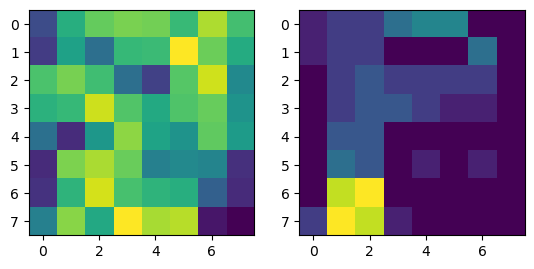

In [154]:
n = 21
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


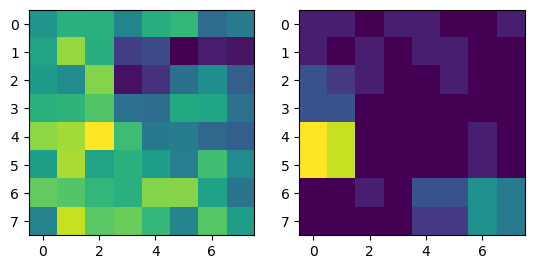

In [155]:
n = 1
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


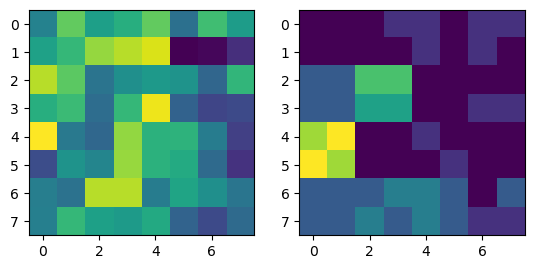

In [156]:
n = 2
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


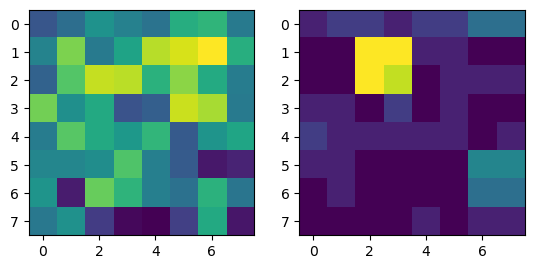

In [157]:
n = 3
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


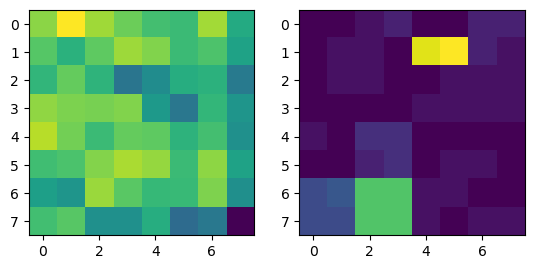

In [158]:
n = 4
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


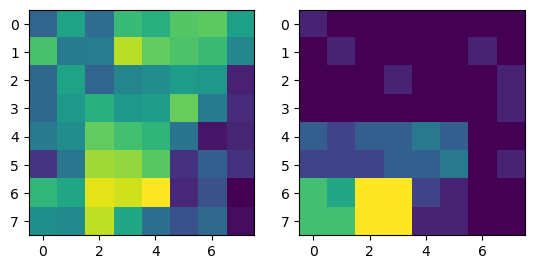

In [159]:
n = 5
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())
# %%

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


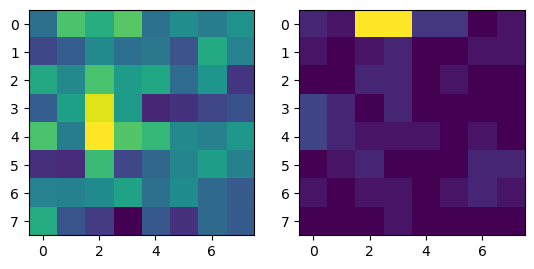

In [160]:
n = 6
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


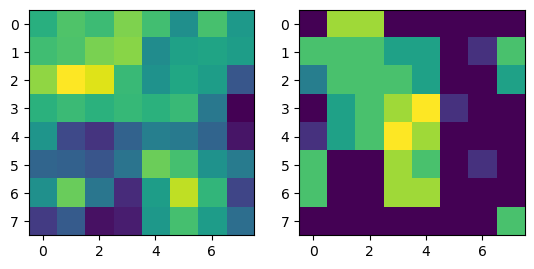

In [161]:
n = 7
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


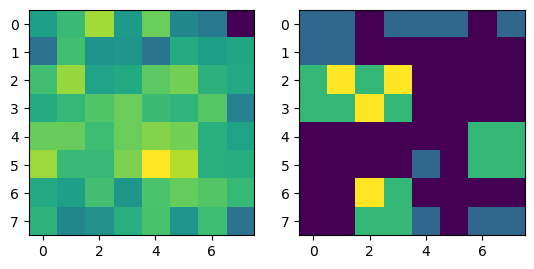

In [162]:
n = 8
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


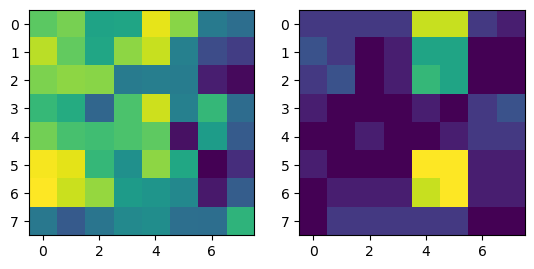

In [163]:
n = 9
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())

torch.Size([1, 3, 368, 368])
torch.Size([1, 1, 8, 8])


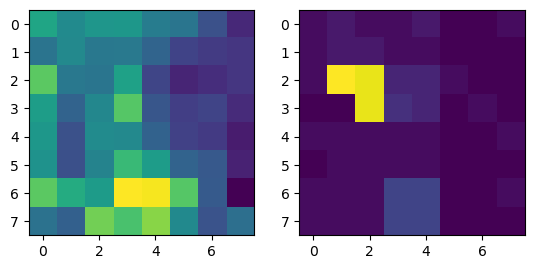

In [164]:
n = 10
x = train_ds[n]['obsvariable'].unsqueeze(0).type(torch.float).to(device)
print(x.shape)
y = train_ds[n]['groundtruth'].to(device)
output=_model(x)
print(output.shape)
# fig, ((ax1,ax2,ax3,ax4,ax5),
#       (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(nrows=2, ncols=5)
# ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
# ax2.imshow(output[0,1,:,:].cpu().detach().numpy())
# ax3.imshow(output[0,2,:,:].cpu().detach().numpy())
# ax4.imshow(output[0,3,:,:].cpu().detach().numpy())
# ax5.imshow(output[0,4,:,:].cpu().detach().numpy())
# ax6.imshow(y[0,:,:].cpu().detach().numpy())
# ax7.imshow(y[1,:,:].cpu().detach().numpy())
# ax8.imshow(y[2,:,:].cpu().detach().numpy())
# ax9.imshow(y[3,:,:].cpu().detach().numpy())
# ax10.imshow(y[4,:,:].cpu().detach().numpy())
fig, (ax1, ax6) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(output[0,0,:,:].cpu().detach().numpy())
ax6.imshow(y[0,:,:].cpu().detach().numpy())